<h2> Importing Important Packages 

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

<h2>Importing Dataset that already preprocessed

In [17]:
path_to_file = 'data/padi.csv'
province = 'DI YOGYAKARTA'
sliding_window = 5
train_test_proportion = 0.8

from preprocessing import preprocess

data = pd.read_csv(path_to_file)
preprocessed = preprocess(data[data['Provinsi'] == province],\
                            sliding_window)

preprocessed.head()

,0,1,2,3,4,5
0,644642,643266,642120,661179,647198,621605
1,643266,642120,661179,647198,621605,612393
2,642120,661179,647198,621605,612393,654289
3,661179,647198,621605,612393,654289,661802
4,647198,621605,612393,654289,661802,653577


<h2> Split Dataset into 2 gourp (train and test test)

In [18]:
train_data = preprocessed[:int(train_test_proportion*preprocessed.shape[0])]
test_data = preprocessed.drop(train_data.index)

train_labels = train_data.pop(train_data.columns[-1])
test_labels = test_data.pop(test_data.columns[-1])

<h2> make Modeling function

In [19]:
def build_model():
    model = keras.Sequential([
        layers.Dense(2, activation=tf.nn.relu,
                     input_shape=[len(train_data.keys())]),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mae', optimizer='adam', metrics=['mse'])

    return model

In [20]:
tf.random.set_seed(28)

model = build_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


<h2> Train Regression model 

In [21]:
epochs = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

history = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=1, callbacks=[early_stop])

===] - 0s 2ms/sample - loss: 102107.8438 - mse: 12165598208.0000 - val_loss: 197842.2500 - val_mse: 39166779392.0000
Epoch 117/1000
11/11 [==============================] - 0s 1ms/sample - loss: 94275.3047 - mse: 10619615232.0000 - val_loss: 189080.8750 - val_mse: 35777482752.0000
Epoch 118/1000
11/11 [==============================] - 0s 1ms/sample - loss: 86368.6094 - mse: 9183488000.0000 - val_loss: 180235.2969 - val_mse: 32511399936.0000
Epoch 119/1000
11/11 [==============================] - 0s 1000us/sample - loss: 78386.9688 - mse: 7860607488.0000 - val_loss: 171304.6875 - val_mse: 29372725248.0000
Epoch 120/1000
11/11 [==============================] - 0s 909us/sample - loss: 70329.6562 - mse: 6654464512.0000 - val_loss: 162288.1875 - val_mse: 26365732864.0000
Epoch 121/1000
11/11 [==============================] - 0s 1ms/sample - loss: 62195.8984 - mse: 5568617984.0000 - val_loss: 153184.9531 - val_mse: 23494819840.0000
Epoch 122/1000
11/11 [==============================] - 0

<h2> Plotting Training Process

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

#Show last Epoch matrics result
hist.tail()

,loss,mse,val_loss,val_mse,epoch
232,30807.205078,1.761958e+09,104742.289062,1.100739e+10,232
233,30798.419922,1.758943e+09,104727.585938,1.100433e+10,233
234,30798.289062,1.758675e+09,104836.898438,1.102724e+10,234
235,30800.642578,1.760886e+09,104801.601562,1.101987e+10,235
236,30797.085938,1.760204e+09,104635.601562,1.098515e+10,236


In [31]:
def ploting_history(history):

    plt.figure(figsize=(14,8))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error (Target)')
    plt.title('Mean Absolute Error values change')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    plt.legend()
    # plt.ylim([0, 5])
    plt.savefig('plot/ABS train history.pdf') 

    plt.figure(figsize=(14,8))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error (Target^2)')
    plt.title('Mean Square Error values change')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.legend()
    # plt.ylim([0, 20])
    plt.savefig('plot/MAE train history.pdf')  

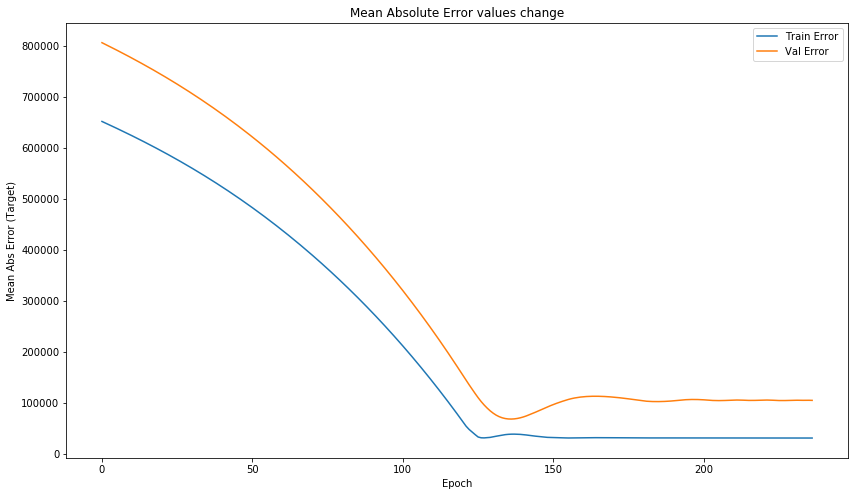

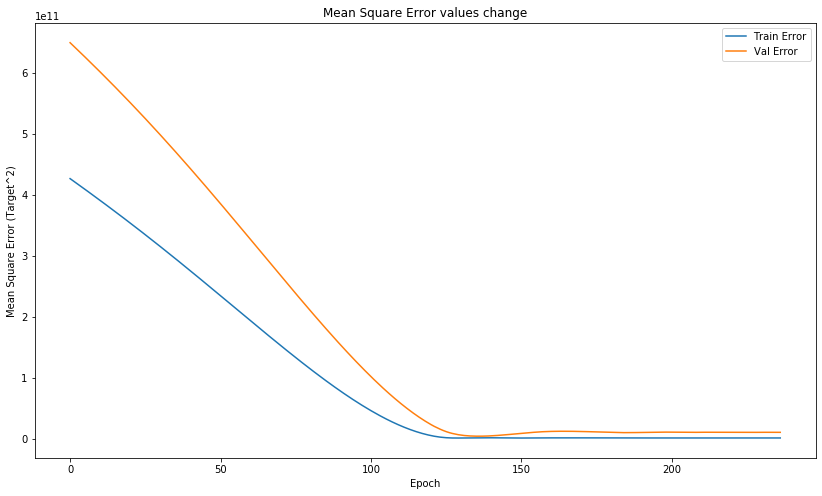

In [32]:
ploting_history(history)

<h2> Checking Evaluation metrics model

In [25]:
model.evaluate(test_data, test_labels, verbose=0)
#     print("Test Set Mean Abs Error : {:5.2f} Comodity in ton".format(mae))

[89869.0, 9863504000.0]

<h2> Predicting Test data

In [26]:
predict = model.predict(test_data).flatten()

predict = pd.DataFrame(list(zip(predict, test_labels.tolist())), 
               columns =['Prediction','Actual'])

predict['error'] = (abs(predict['Actual'] - predict['Prediction'])/
                               predict['Prediction'])
predict

,Prediction,Actual,error
0,783822.8750,946224,0.207191
1,861007.8125,921824,0.070634
2,858445.9375,919573,0.071207
3,870004.3750,945136,0.086358


In [27]:
print(predict.error.mean())

0.10884730846631764


In [28]:
loss, mse = model.evaluate(test_data, test_labels, verbose=0)
print("Mean Absolute Error : {:5.2f} Comodity in ton".format(loss))
print("Mean Squared Error : {:5.2f} Comodity in ton".format(mse))
print(predict.error.mean())

Mean Absolute Error : 89869.00 Comodity in ton
Mean Squared Error : 9863503872.00 Comodity in ton
0.10884730846631764
